# Analysis Of Parameter Fitting All Genes In Preliminary Dataset

##### Modules

In [1]:
import os
os.chdir(os.path.dirname(os.getcwd()))

import numpy as np
from data_handler import DataHandler
from droplet_model import DropletModel, ReparameterisedDropletModel, DropletModelUnknownInitialConditions
from parameter_fitting import ParameterFitting
from plots import Plots
import matplotlib.pyplot as plt
import pints
import pints.plot
from scipy.integrate import odeint
from numba import njit
import seaborn as sns
from cycler import cycle
import scipy.stats as st
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import json
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

plotter = Plots()
data_handler = DataHandler()

##### Functions and Methods

In [18]:
def plot_mle_solution(
    model, 
    data,
    data_times,
    param_mles,
    sigma_mles,
    z_value = 1.96,
    max_size_shown=None,
    fig_size=(8,5),
    noise_model="additive normal",
    y_max=None,
    title=None,
    save_fig=False,
    save_path=None
):
    
    def _style_axes(
        fig,
        ax,
        ticksize=14,
        labelsize=20,
        y_max=None
    ):
        

        xlabel = "time, " + r"$t$"
        ylabel = "droplet count, " + r"$\phi_n(t)$"



        ax.set_ylabel(ylabel, fontsize=labelsize, fontweight='bold')

        for tick in ax.get_xticklabels() + ax.get_yticklabels():
            tick.set_fontsize(ticksize)


        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # ax.spines['left'].set_linewidth(2)
        # ax.spines['bottom'].set_linewidth(2)

        ax.set_xlabel(xlabel, fontsize=labelsize, fontweight='bold')

        if y_max is not None:
            ax.set_ylim(ax.get_ylim()[0], y_max)

        

    
    fig, ax = plt.subplots(figsize=fig_size)
    
    model_params = param_mles


    num_model_times = 200
    model_times = np.linspace(4, 14, num_model_times)

    num_outputs = model.n_outputs()
    if max_size_shown is None:
        max_size_shown = num_outputs
    
    opt_model_sol = model.simulate(params=model_params, times=model_times)


    palette = sns.color_palette("Set1", n_colors=max_size_shown)
    colour_cycle = cycle(palette)

    for n in range(max_size_shown):

        opt_model_sol_n = opt_model_sol[:, n]

        if noise_model == "additive normal":
            model_lower = opt_model_sol_n - z_value * sigma_mles[n]
            model_upper = opt_model_sol_n + z_value * sigma_mles[n]
        elif noise_model == "multiplicative normal":
            model_lower = opt_model_sol_n * (1 - z_value * sigma_mles[n]) 
            model_upper = opt_model_sol_n * (1+ z_value * sigma_mles[n])
        elif noise_model == "lognormal":
            model_lower = opt_model_sol_n * np.exp(- z_value * sigma_mles[n])
            model_upper = opt_model_sol_n * np.exp(z_value * sigma_mles[n])
        else:
            raise ValueError("noise model not valid")


        plot_colour = next(colour_cycle)
        ax.plot(data_times, data[:, n], marker='s', markersize=10, markeredgecolor='k', linestyle='--', label='data', c=plot_colour)
        ax.plot(model_times, opt_model_sol_n, linewidth=4, label='model', c=plot_colour)
        ax.fill_between(model_times,model_lower,model_upper,color=plot_colour,alpha=0.1,label=f'95% CI')

    
    _style_axes(
        fig=fig,
        ax=ax,
        y_max=y_max
    )

    ax.set_title(title, fontsize=16, fontweight='bold')

    if not save_fig:
        plt.show()

    else:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path)   # save the figure to file
        plt.close(fig) 



def generate_synthetic_data(
    model,
    model_params,
    data_times,
    sigma_values,
    noise_factor=None,
    noise_model="additive normal",
    rng=None
):
    
    model_sol = model.simulate(model_params, data_times)
    N = model.n_outputs()
    T = len(data_times)


    if sigma_values is None:

        sigma_values = noise_factor * np.std(model_sol, axis=0)

    if rng is None:
        rng = np.random.default_rng()

    eps = rng.normal(loc=0.0, scale=sigma_values.reshape(1, N), size=(T, N))

    if noise_model == "additive normal":

        synthetic_prediction = model_sol + eps
        
    elif noise_model == "multiplicative normal":

        synthetic_prediction = model_sol * (1 + eps)

    elif noise_model == "lognormal":

        synthetic_prediction = model_sol * np.exp(eps)

    return sigma_values, synthetic_prediction



def get_sigma_MLEs(
    model, 
    data, 
    mle_params, 
    data_times, 
    noise_model="additive normal"
):

    opt_model_sol = model.simulate(mle_params, data_times)
    residuals = opt_model_sol - data

    n_t = len(data_times)

    if noise_model == "additive normal":

        sigma_MLEs = np.sqrt((1 / n_t) * np.sum(residuals**2, axis=0))

    elif noise_model == "multiplicative normal":

        sigma_MLEs = np.sqrt((1 / n_t) * np.sum(residuals**2 / opt_model_sol**2, axis=0))

    elif noise_model == "lognormal":

        log_residuals = np.log(data) - np.log(opt_model_sol)

        log_residuals = np.nan_to_num(log_residuals, nan=0)

        sigma_MLEs = np.sqrt((1 / n_t) * np.sum(log_residuals**2, axis=0))

    return sigma_MLEs



def get_opt_parameters(
    log_likelihood,
    opt_lower_bounds,
    opt_upper_bounds,
    log_transform_opt=True,
    opt_method=pints.CMAES,
    opt_initial_position=None,
    display_log=True,
    num_optimisations=10
):
    """
    Run `num_optimisations` optimisations and return the best params found (as numpy array).
    If opt_initial_position is None: sample a fresh random start for each run.
    If opt_initial_position is provided: use the same start for every run.
    """

    opt_bounds = pints.RectangularBoundaries(opt_lower_bounds, opt_upper_bounds)
    log_prior = pints.UniformLogPrior(opt_bounds)

    if log_transform_opt:
        transformation = pints.LogTransformation(n_parameters=len(opt_lower_bounds))
    else:
        transformation = None

    best_score = -np.inf
    best_params = None

    for j in range(1, num_optimisations + 1):
        # pick initial position for this run (do not overwrite user-supplied opt_initial_position)
        if opt_initial_position is None:
            # log_prior.sample(1) often returns an array shaped (1, n); take [0] to get 1D
            init = np.asarray(log_prior.sample(1)).reshape(-1)
        else:
            init = np.asarray(opt_initial_position).reshape(-1)

        opt = pints.OptimisationController(
            log_likelihood,
            init,
            boundaries=opt_bounds,
            method=opt_method,
            transformation=transformation
        )

        opt.set_log_to_screen(display_log)
        # opt.set_max_unchanged_iterations(200, 1e-11)

        opt_params, opt_score = opt.run()

        if num_optimisations > 1:
            print(f"Iteration {j}/{num_optimisations}: opt_params: {opt_params} ; score: {opt_score}")

        # compare scores (assumes larger is better for your objective - typical for log-likelihood)
        if opt_score > best_score:
            best_score = opt_score
            best_params = np.asarray(opt_params)

    if best_params is None:
        raise RuntimeError("No optimisation results produced.")

    return best_params



def get_mcmc_chains(
    log_likelihood,
    apply_log_transform = False,
    mcmc_method = pints.HaarioBardenetACMC,
    max_mcmc_iterations = 30000,
    num_chains = 4,
    prior_lower_bounds = [1e1, 1e-10, 1e-2],
    prior_upper_bounds = [1e4, 1e0, 1e1],
    specified_log_prior=None,
    initial_mcmc_points=None,
    log_to_screen=True
):

    if specified_log_prior is None:
        
        prior_bounds = pints.RectangularBoundaries(prior_lower_bounds, prior_upper_bounds)
        log_prior = pints.UniformLogPrior(prior_bounds)

    else:

        log_prior = specified_log_prior


    if initial_mcmc_points is None:
        initial_mcmc_points = log_prior.sample(num_chains)


    mcmc_transform = None
    if apply_log_transform:

        mcmc_transform = pints.LogTransformation(n_parameters=log_likelihood._n_parameters)

    log_posterior = pints.LogPosterior(log_likelihood, log_prior)

    mcmc = pints.MCMCController(log_posterior, num_chains, initial_mcmc_points, method=mcmc_method, transformation=mcmc_transform)
    mcmc.set_max_iterations(max_mcmc_iterations)
    # mcmc.set_parallel(True)
    mcmc.set_log_to_screen(log_to_screen)

    chains = mcmc.run()

    return chains



def get_standardised_residuals(
    model,
    data,
    data_times,
    mle_params,
    noise_model
):
    
    model_sol = model.simulate(mle_params, data_times)

    sigma_mles = get_sigma_MLEs(
        model=model,
        data=data,
        mle_params=mle_params,
        data_times=data_times,
        noise_model=noise_model
    )

    if noise_model == "additive normal":

        residuals = data - model_sol
        std_residuals = residuals / sigma_mles
        
    elif noise_model == "multiplicative normal":

        residuals = (data - model_sol) / model_sol
        std_residuals = residuals / sigma_mles

    elif noise_model == "lognormal":

        residuals = np.log(data) - np.log(model_sol)
        std_residuals = residuals / sigma_mles

    return std_residuals


def percentile_interval(samples_1d, prob=0.95):
    """Return (lo, hi) central percentile credible interval for 1D samples."""
    lo = 100 * (1 - prob) / 2.0
    hi = 100 * (1 + prob) / 2.0
    return np.percentile(samples_1d, [lo, hi])

def hpd_interval(samples_1d, prob=0.95):
    """
    Compute the shortest interval containing `prob` fraction of samples (HPD approx).
    Returns (lo, hi).
    Note: for multimodal distributions this returns the shortest single interval,
    which may not represent multiple disjoint high-density regions.
    """
    x = np.sort(samples_1d)
    n = x.size
    m = int(np.floor(prob * n))
    if m < 1:
        raise ValueError("Too few samples for requested probability")
    # compute widths of all intervals of size m
    intervals_start = x[: n - m]
    intervals_end   = x[m: ]
    widths = intervals_end - intervals_start
    min_idx = np.argmin(widths)
    return (intervals_start[min_idx], intervals_end[min_idx])

# Apply to every column (parameter) in the 2D array:
def summarize_intervals(samples, prob=0.95):
    """
    samples: array shape (n_samples, n_params)
    Returns dict with percentile and hpd intervals per parameter index.
    """
    n_params = samples.shape[1]
    result = {}
    for i in range(n_params):
        col = samples[:, i]
        p_lo, p_hi = percentile_interval(col, prob=prob)
        h_lo, h_hi = hpd_interval(col, prob=prob)
        result[i] = {
            "percentile": (float(p_lo), float(p_hi)),
            "hpd": (float(h_lo), float(h_hi)),
            "mean": float(np.mean(col)),
            "median": float(np.median(col)),
            "std": float(np.std(col, ddof=1))
        }
    return result

##### Log-likelihoods

In [3]:
class AdditivenormalLogLikelihood(pints.ProblemLogLikelihood):

    def __init__(self, problem, use_profile=True, eps=1e-12, mask_threshold=0.0):
        super(AdditivenormalLogLikelihood, self).__init__(problem)

        # Get number of times, number of outputs
        self._nt = len(self._times)
        self._no = problem.n_outputs()

        # Add parameters to problem

        self.use_profile = use_profile

        if self.use_profile:
            self._n_parameters = problem.n_parameters()
        else:
            self._n_parameters = problem.n_parameters() + self._no

        self._eps = eps
        self._mask_threshold = mask_threshold

        # Pre-calculate parts

        # For a log-normal sampling distribution any data points being below
        # zero would mean that the log-likelihood is always -infinity
        # Boolean mask: True for columns with NO zeros

        vals = self._values

        mask = np.all(vals > self._mask_threshold, axis=0)

        # Indices of size classes kept
        kept_indices = np.where(mask)[0]

        # New vals array with only those size classes
        self.values_filtered = vals[:, mask]

        self._no_filtered = self.values_filtered.shape[1]



    def __call__(self, x):

        sigmas = np.asarray(x[-self._no:])

        if self.use_profile:

            soln = self._problem.evaluate(x[:-self._no])

        else:

            soln = self._problem.evaluate(x)

        ll = 0.0

        for i in range(0, self._no_filtered):

            model_n = soln[:, i]
            data_n = self.values_filtered[:, i]

            res = (data_n - model_n + self._eps)**2

            if self.use_profile:

                sigma_n = np.sqrt((1 / self._nt) * np.sum(res))

            else:

                sigma_n = sigmas[i]

            term1 = -0.5 * self._nt * np.log(2 * np.pi)

            term2 = -0.5 * self._nt * np.log(sigma_n**2 + self._eps)

            term3 = -0.5 * self._nt

            ll_n = term1 + term2 + term3

            # print(f"n = {i+1}, ll_n = {ll_n}")

            ll += ll_n

        return ll



class MultiplicativenormalLogLikelihood(pints.ProblemLogLikelihood):

    def __init__(self, problem, use_profile=True, eps=1e-12, mask_threshold=0.0):
        super(MultiplicativenormalLogLikelihood, self).__init__(problem)

        # Get number of times, number of outputs
        self._nt = len(self._times)
        self._no = problem.n_outputs()

        self.use_profile = use_profile

        if self.use_profile:
            self._n_parameters = problem.n_parameters()
        else:
            self._n_parameters = problem.n_parameters() + self._no

        self._eps = eps
        self._mask_threshold = mask_threshold

        # Pre-calculate parts

        # For a log-normal sampling distribution any data points being below
        # zero would mean that the log-likelihood is always -infinity
        # Boolean mask: True for columns with NO zeros

        vals = self._values

        mask = np.all(vals > self._mask_threshold, axis=0)

        # Indices of size classes kept
        kept_indices = np.where(mask)[0]

        # New vals array with only those size classes
        self.values_filtered = vals[:, mask]

        self._no_filtered = self.values_filtered.shape[1]



    def __call__(self, x):

        sigmas = np.asarray(x[-self._no:])

        if self.use_profile:

            soln = self._problem.evaluate(x[:-self._no])

        else:

            soln = self._problem.evaluate(x)

        ll = 0.0

        for i in range(0, self._no_filtered):

            model_n = soln[:, i]
            data_n = self.values_filtered[:, i]

            res = (data_n - model_n + self._eps)**2 / (model_n + self._eps)**2

            if self.use_profile:

                sigma_n = np.sqrt((1 / self._nt) * np.sum(res))

            else:

                sigma_n = sigmas[i]

            term1 = -0.5 * self._nt * np.log(2 * np.pi)

            term2 = -0.5 * self._nt * np.log(sigma_n**2 + self._eps)

            term3 = -0.5 * np.sum(np.log(model_n**2 + self._eps))

            term4 = -0.5 * self._nt

            ll_n = term1 + term2 + term3 + term4

            # print(f"n = {i+1}, ll_n = {ll_n}")

            ll += ll_n

        return ll
    


class LognormalLogLikelihood(pints.ProblemLogLikelihood):

    def __init__(self, problem, use_profile=True, eps=1e-12, mask_threshold=0.0):
        super(LognormalLogLikelihood, self).__init__(problem)

        # Get number of times, number of outputs
        self._nt = len(self._times)
        self._no = problem.n_outputs()

        self.use_profile = use_profile

        if self.use_profile:
            self._n_parameters = problem.n_parameters()
        else:
            self._n_parameters = problem.n_parameters() + self._no

        self._eps = eps
        self._mask_threshold = mask_threshold

        # Pre-calculate parts

        # For a log-normal sampling distribution any data points being below
        # zero would mean that the log-likelihood is always -infinity
        # Boolean mask: True for columns with NO zeros

        vals = self._values

        mask = np.all(vals > self._mask_threshold, axis=0)

        # Indices of size classes kept
        kept_indices = np.where(mask)[0]

        # New vals array with only those size classes
        self.values_filtered = vals[:, mask]

        self._no_filtered = self.values_filtered.shape[1]



    def __call__(self, x):

        sigmas = np.asarray(x[-self._no:])

        if self.use_profile:

            soln = self._problem.evaluate(x[:-self._no])

        else:

            soln = self._problem.evaluate(x)

        ll = 0.0

        for i in range(0, self._no_filtered):

            model_n = soln[:, i]
            data_n = self.values_filtered[:, i]

            log_res = (np.log(data_n + self._eps) - np.log(model_n + self._eps))**2

            if self.use_profile:

                sigma_n = np.sqrt((1 / self._nt) * np.sum(log_res))

            else:

                sigma_n = sigmas[i]

            term1 = -0.5 * self._nt * np.log(2 * np.pi)

            term2 = -0.5 * self._nt * np.log(sigma_n**2 + self._eps)

            term3 = -0.5 * np.sum(np.log(data_n**2 + self._eps))

            term4 = -0.5 * self._nt

            ll_n = term1 + term2 + term3 + term4

            # print(f"n = {i+1}, ll_n = {ll_n}")

            ll += ll_n

        return ll



def get_log_likelihood(
    problem,
    noise_model,
    use_profile=True,
    mask_threshold=1        
):


    if noise_model == "additive normal":

        log_likelihood = AdditivenormalLogLikelihood(
            problem=problem,
            use_profile=use_profile,
            mask_threshold=mask_threshold
        )

    elif noise_model == "multiplicative normal":

        log_likelihood = MultiplicativenormalLogLikelihood(
            problem=problem,
            use_profile=use_profile,
            mask_threshold=mask_threshold
        )

    elif noise_model == "lognormal":

        log_likelihood = LognormalLogLikelihood(
            problem=problem,
            use_profile=use_profile,
            mask_threshold=mask_threshold
        )

    else:

        raise ValueError(f"Noise model, {noise_model}, is not a valid nosie model!")





    return log_likelihood

##### Plotting functions

In [4]:
def get_gene_colour(gene_id, gene_groups, gene_group_colours):
    return next(
        (gene_group_colours[group]
         for group, genes in gene_groups.items()
         if gene_id in genes),
        None
    )



def get_transformed_params(params, params_transforms):

    transformed_params = np.asarray(params) / np.asarray(params_transforms)

    return transformed_params


def get_transform_powers(params_transforms):

    return np.log10(params_transforms).astype(int)


def _style_axes(
    ax,
    x_label,
    y_label,
    ticksize=14,
    labelsize=16
):

    for tick in ax.get_xticklabels() + ax.get_yticklabels():
        tick.set_fontsize(ticksize)
        tick.set_fontweight('bold')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)

    ax.set_xlabel(x_label, fontsize=labelsize, fontweight='bold')
    ax.set_ylabel(y_label, fontsize=labelsize, fontweight='bold')

---

## Analysis

### Parameter spaces across pools

In [29]:
def point_estimate_parameter_space(
    noise_model="additive normal",
    params_transforms=[1e3, 1e-5, 1e-1],
    fig_size=(16,6),
    nondim=None,
    use_legend=False,
    save_fig=False,
    save_path=None
):
    

    def _make_legend(
        fig,
        axes,
        marker_styles=None
    ):
        
        ax = axes[1]

        # create blank rectangle
        extra = mpatches.Rectangle((0, 0), 0.1, 0.1, fc="w", fill=False, edgecolor='none', linewidth=0)

        # data_key = mpatches.Patch("*", color="k")


        empty = Line2D([], [], linestyle="none")

        header = Line2D([], [], linestyle="none")

        legend_handles = [
            # --- Column 1 (Pool 1) ---
            extra,
            Line2D([], [], marker='o', linestyle='None',
                markeredgecolor='k', color='w', markersize=10),
            Line2D([], [], marker='*', linestyle='None',
                markeredgecolor='k', color='w', markersize=10),

            # --- Column 2 (Pool 2) ---
            extra,
            Line2D([], [], marker='s', linestyle='None',
                markeredgecolor='k', color='w', markersize=10),
            Line2D([], [], marker='P', linestyle='None',
                markeredgecolor='k', color='w', markersize=10),
        ]

        legend_labels = [
            "Pool 1",
            "",
            "",
            "Pool 2",
            "Non-control",
            "Control",
        ]


        fig.subplots_adjust(right=0.8)

        ax.legend(
            legend_handles,
            legend_labels,
            loc="center left", 
            bbox_to_anchor=(0.8, 0.5), 
            bbox_transform=fig.transFigure, 
            ncol=2, 
            columnspacing=0
        )

    

    def _style_axes(
        ax,
        ax_index,
        param1_index,
        param2_index,
        params_transforms,
        ticksize=14,
        labelsize=20
    ):
        
        param_names = ["b", "f", "g"]

        param1 = param_names[param1_index]
        param2 = param_names[param2_index]

        transform_powers = get_transform_powers(params_transforms)

        xlabel = rf"{param1} $\left(\times 10^{{{int(transform_powers[param1_index])}}}\right)$"
        ylabel = rf"{param2} $\left(\times 10^{{{int(transform_powers[param2_index])}}}\right)$"

        if ax_index == 0:

            ax.set_ylabel(ylabel, fontsize=labelsize)

            for tick in ax.get_xticklabels() + ax.get_yticklabels():
                tick.set_fontsize(ticksize)
                tick.set_fontweight('bold')

        if ax_index == 1:

            for tick in ax.get_xticklabels():
                tick.set_fontsize(ticksize)
                tick.set_fontweight('bold')

            for tick in ax.get_yticklabels():
                tick.set_visible(False)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)

        ax.set_xlabel(xlabel, fontsize=labelsize)


    

    def _plot_point_estimates(
        ax,
        ax_index,
        pool_id,
        gene_id,
        opt_params_df,
        params_transforms,
        param1_index,
        param2_index,
        marker_style,
        nondim=None
    ):
        
        data_array = data_handler.get_gene_average_array(pool_id=pool_id, gene_id=gene_id, max_bin_number=51)
        initial_conditions = data_array[0]
        
        opt_params_row = opt_params_df.loc[opt_params_df["gene_id"] == gene_id].iloc[0]

        opt_model_params = np.asarray([opt_params_row["b"], opt_params_row["f"], opt_params_row["g"]])

        params_to_transform = opt_model_params

        if nondim is  not None:

            if nondim == "phi1":

                transform = initial_conditions[0]

            elif nondim == "M0":

                transform = np.sum(initial_conditions)

            else:

                raise ValueError("nondim not a valid value")
        
            params_to_transform[0] = opt_model_params[0] / transform
            params_to_transform[1] = opt_model_params[1] * transform

        transformed_params = get_transformed_params(params_to_transform, params_transforms)

        gene_colour = data_handler.get_gene_colour(gene_id=gene_id)

        ax.scatter(
            transformed_params[param1_index], 
            transformed_params[param2_index], 
            color=gene_colour,
            marker=marker_style["markerstyle"],
            s=marker_style["size"],
            edgecolor=marker_style["edgecolour"],
            alpha=marker_style["alpha"],
            label=marker_style["label"]
        )

        _style_axes(
            ax=ax,
            ax_index=ax_index,
            param1_index=param1_index,
            param2_index=param2_index,
            params_transforms=params_transforms
        )


    fig, axes = plt.subplots(1, 2, figsize=fig_size, gridspec_kw={"wspace": 0.01, "hspace": 0})

    param_names = ["b", "f", "g"]

    for ax_index, ax in enumerate(axes):

        pool_ids = [1,2]

        pool_control_markers = ["*", "P"]
        pool_gene_markers = ["o", "s"]

        for p, pool_id in enumerate(pool_ids):

            read_file_path = Path(f"../Results/{noise_model}/preliminary dataset/pool {pool_id}/opt_params.csv")
            opt_params_df = pd.read_csv(read_file_path, low_memory=False, keep_default_na=False)

            all_gene_ids = data_handler.get_pool_gene_ids(pool_id=pool_id)
            control_genes = [g for g in data_handler.control_ids if g != "NA"]
            non_control_genes = [g for g in all_gene_ids if (g not in control_genes) and (g != "NA")]


            marker_styles = {
                "pool 1": {
                    "non_control": {
                        "markerstyle": "o",
                        "edgecolour": "k",
                        "alpha": 0.65,
                        "size": 200,
                        "label": None
                    },
                    "control": {
                        "markerstyle": "*",
                        "edgecolour": "k",
                        "alpha": 1,
                        "size": 750,
                        "label": None
                    },
                },
                "pool 2": {
                    "non_control": {
                        "markerstyle": "s",
                        "edgecolour": "k",
                        "alpha": 0.65,
                        "size": 200,
                        "label": None
                    },
                    "control": {
                        "markerstyle": "P",
                        "edgecolour": "k",
                        "alpha": 1,
                        "size": 500,
                        "label": None
                    },
                }
            }

            for i, gene_id in enumerate(non_control_genes):

                _plot_point_estimates(
                    ax=ax,
                    ax_index=ax_index,
                    pool_id=pool_id,
                    gene_id=gene_id,
                    opt_params_df=opt_params_df,
                    params_transforms=params_transforms,
                    param1_index=1+ax_index,
                    param2_index=0,
                    marker_style=marker_styles[f"pool {pool_id}"]["non_control"],
                    nondim=nondim
                )

            for i, gene_id in enumerate(control_genes):

                _plot_point_estimates(
                    ax=ax,
                    ax_index=ax_index,
                    pool_id=pool_id,
                    gene_id=gene_id,
                    opt_params_df=opt_params_df,
                    params_transforms=params_transforms,
                    param1_index=1+ax_index,
                    param2_index=0,
                    marker_style=marker_styles[f"pool {pool_id}"]["control"],
                    nondim=nondim
                )

    fig.suptitle(f"Parameter space (assuming {noise_model} noise)", fontsize=20, fontweight="bold")

    if use_legend:
        _make_legend(fig, axes)

    if not save_fig:
        plt.show()

    else:

        fig.savefig(save_path)   # save the figure to file
        plt.close(fig) 



In [33]:
noise_model = "lognormal"

save_path = Path(f"../Results/{noise_model}/preliminary dataset/MLE_parameter_space.png")

point_estimate_parameter_space(
    noise_model=noise_model,
    params_transforms=[1e3, 1e-5, 1e-1],
    fig_size=(20,10),
    save_fig=True,
    save_path=save_path
)

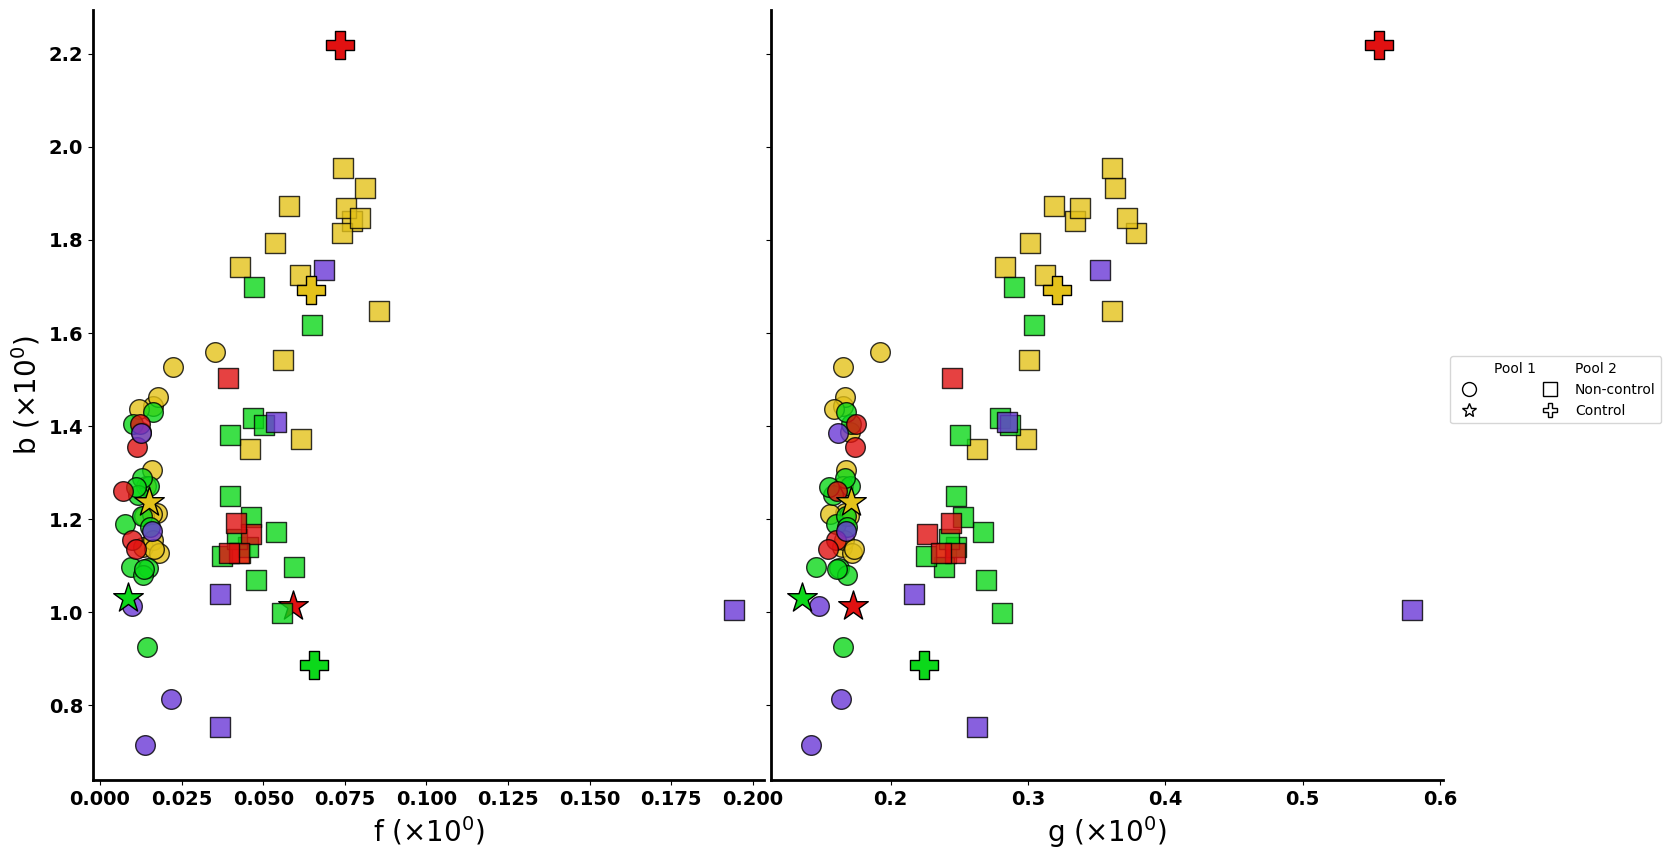

In [7]:
point_estimate_parameter_space(
    noise_model="additive normal",
    params_transforms=[1, 1, 1],
    fig_size=(20,10),
    nondim="M0"
)

---

### Non-dimensionalised parameter space across pools

In [150]:
def nondim_point_estimate_parameter_space(
    noise_model="additive normal",
    params_transforms=[1, 1, 1],
    fig_size=(10,10)
):
    

    

    def _plot_nondim_point_estimates(
        ax,
        gene_id,
        opt_params_df,
        gene_marker,
        gene_markersize,
        gene_marker_alpha=1
    ):
        
        opt_params_row = opt_params_df.loc[opt_params_df["gene_id"] == gene_id].iloc[0]

        opt_model_params = np.asarray([opt_params_row["b"], opt_params_row["f"], opt_params_row["g"]])

        alpha = opt_model_params[0] * opt_model_params[1] / opt_model_params[2]**2
        g = opt_model_params[2]

        gene_colour = data_handler.get_gene_colour(gene_id=gene_id)

        ax.scatter(
            alpha, 
            g, 
            color=gene_colour,
            marker=gene_marker,
            s=gene_markersize,
            edgecolor='k',
            alpha=gene_marker_alpha
        )

        # _style_axes(
        #     ax=ax,
        #     ax_index=ax_index,
        #     param1_index=param1_index,
        #     param2_index=param2_index
        # )


    fig, ax = plt.subplots(figsize=fig_size)

    nondim_param_names = ["alpha", "g"]

    pool_ids = [1,2]


    for p, pool_id in enumerate(pool_ids):

        read_file_path = Path(f"../Results/{noise_model}/preliminary dataset/pool {pool_id}/opt_params.csv")
        opt_params_df = pd.read_csv(read_file_path, low_memory=False, keep_default_na=False)

        all_gene_ids = data_handler.get_pool_gene_ids(pool_id=pool_id)
        control_genes = [g for g in data_handler.control_ids if g != "NA"]
        non_control_genes = [g for g in all_gene_ids if (g not in control_genes) and (g != "NA")]

        pool_control_markers = ["*", "P"]
        pool_gene_markers = ["o", "s"]

        for i, gene_id in enumerate(non_control_genes):

            _plot_nondim_point_estimates(
                ax=ax,
                gene_id=gene_id,
                opt_params_df=opt_params_df,
                gene_marker=pool_gene_markers[p],
                gene_markersize=100,
                gene_marker_alpha=1,
            )

        for i, gene_id in enumerate(control_genes):

            _plot_nondim_point_estimates(
                ax=ax,
                gene_id=gene_id,
                opt_params_df=opt_params_df,
                gene_marker=pool_control_markers[p],
                gene_markersize=100,
                gene_marker_alpha=1,
            )



    plt.show()

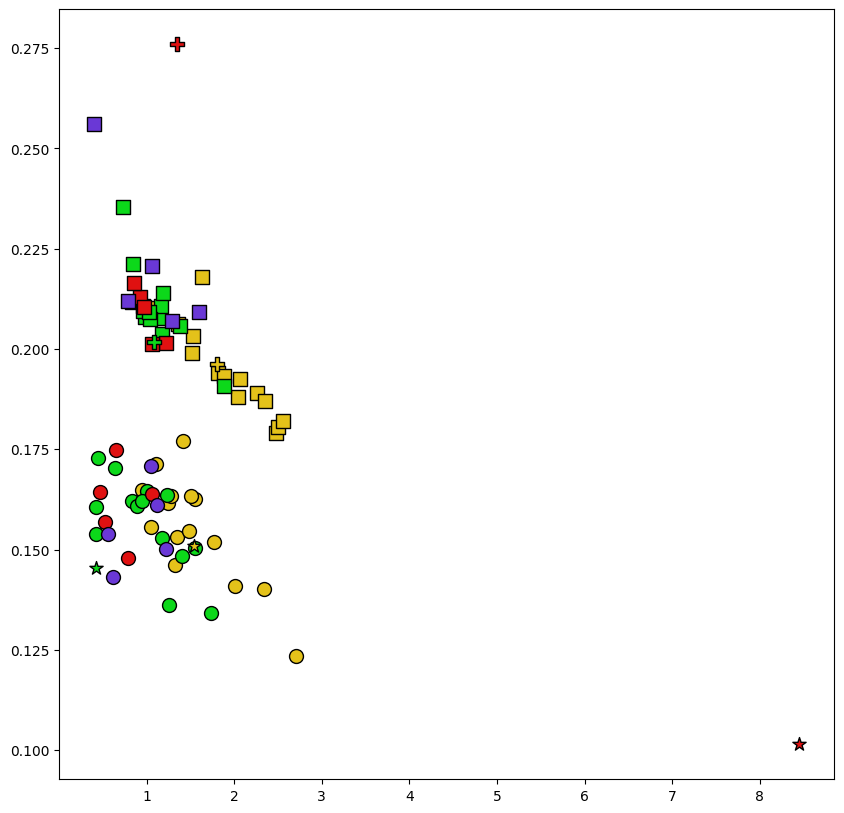

In [153]:
nondim_point_estimate_parameter_space(noise_model="lognormal")

---

### MCMC parameter spaces testing

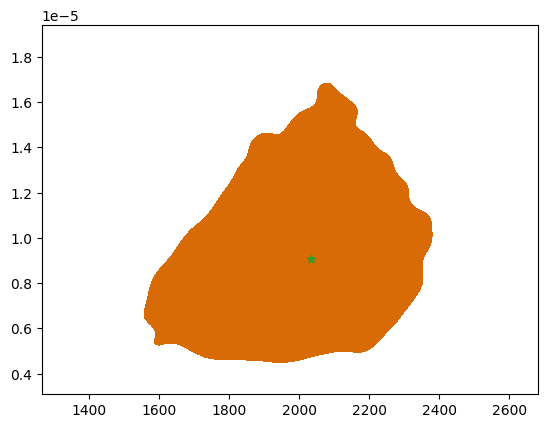

In [10]:
burnt_in_chains = []
num_chains = 4

noise_model = "additive normal"
pool_id = 1
gene_id = "NTC (avg)"

opt_params_read_path = Path(f"../Results/{noise_model}/preliminary dataset/pool {pool_id}/opt_params.csv")

opt_params_df = pd.read_csv(opt_params_read_path, low_memory=False, keep_default_na=False)

opt_params_row = opt_params_df.loc[opt_params_df["gene_id"] == gene_id].iloc[0]

opt_model_params = np.asarray([opt_params_row["b"], opt_params_row["f"], opt_params_row["g"]])

for c in range(num_chains):

    read_path = Path(f"../Results/{noise_model}/preliminary dataset/pool {pool_id}/{gene_id}/profile mcmc/chain {c+1}.csv")

    chain = pd.read_csv(read_path, low_memory=False, keep_default_na=False).to_numpy()

    burnt_in_chain = chain[int(chain.shape[0]/2):, :]

    burnt_in_chains.append(burnt_in_chain)

stacked_chains = np.vstack(burnt_in_chains)

rng = np.random.default_rng(seed=1)
num_samples = 10000

sample_idx = rng.choice(len(stacked_chains), size=num_samples, replace=False)
chains_sample = stacked_chains[sample_idx]

chains_mean = np.mean(stacked_chains, axis=0)

plt.scatter(chains_mean[0], chains_mean[1])
sns.kdeplot(x=chains_sample[:, 0], y=chains_sample[:, 1], levels=[0.05, 1], fill=True)

plt.scatter(opt_model_params[0], opt_model_params[1], marker="*")
plt.show()

In [11]:
samples=chains_sample
intervals = summarize_intervals(samples, prob=0.95)
for i, info in intervals.items():
    print(f"Param {i}: mean={info['mean']}, median={info['median']}, std={info['std']}")
    print(f"  95% percentile CI: {info['percentile']}")
    print(f"  95% HPD interval   : {info['hpd']}")

Param 0: mean=2008.8824273077503, median=2020.2007950997877, std=149.84342706137485
  95% percentile CI: (1671.7140115624159, 2280.613310698947)
  95% HPD interval   : (1675.8510793745772, 2282.112833329408)
Param 1: mean=9.278390246390981e-06, median=9.081519503021601e-06, std=2.2463574780390477e-06
  95% percentile CI: (5.483509497140236e-06, 1.435764828286693e-05)
  95% HPD interval   : (5.009248193517903e-06, 1.3538430561477034e-05)
Param 2: mean=0.17320134018695274, median=0.172990543993471, std=0.021531803045005637
  95% percentile CI: (0.1323163758503649, 0.2174678554539663)
  95% HPD interval   : (0.1323163758503649, 0.2174431592421085)


---

### MLE fits

In [24]:
noise_model = "lognormal"

pool_ids = [1,2]

pool_control_markers = ["*", "P"]
pool_gene_markers = ["o", "s"]

for p, pool_id in enumerate(pool_ids):

    read_file_path = Path(f"../Results/{noise_model}/preliminary dataset/pool {pool_id}/opt_params.csv")
    opt_params_df = pd.read_csv(read_file_path, low_memory=False, keep_default_na=False)

    all_gene_ids = data_handler.get_pool_gene_ids(pool_id=pool_id)
    control_genes = [g for g in data_handler.control_ids if g != "NA"]
    non_control_genes = [g for g in all_gene_ids if (g not in control_genes) and (g != "NA")]

    # all_gene_ids = ["NTC (avg)"]

    for g, gene_id in enumerate(all_gene_ids):

        opt_params_row = opt_params_df[opt_params_df["gene_id"] == gene_id].iloc[0].to_numpy()[1:]
        
        opt_model_mles = opt_params_row[:3]

        if noise_model == "least squares":

            opt_sigma_mles = list(opt_params_row[3:]) * 51

        else:

            opt_sigma_mles = opt_params_row[3:]

        data_array = data_handler.get_gene_average_array(pool_id=pool_id, gene_id=gene_id, max_bin_number=51)
        initial_conditions = data_array[0]

        model = DropletModel(initial_conditions=initial_conditions)
        data_times = data_handler.data_times

        title = f"{gene_id} - [{data_handler.dataset}, pool {pool_id}]"

        save_path = f"../Results/{noise_model}/preliminary dataset/pool {pool_id}/{gene_id}/pool {pool_id} {gene_id} MLE timecourse plot.png"

        plot_noise_model = noise_model
        if noise_model == "least squares":
            plot_noise_model = "additive normal"

        plot_mle_solution(
            model=model,
            data=data_array,
            data_times=data_times,
            param_mles=opt_model_mles,
            sigma_mles=opt_sigma_mles,
            max_size_shown=4,
            fig_size=(10,6),
            noise_model=plot_noise_model,
            y_max=11000,
            title=title,
            save_fig=True,
            save_path=save_path
        )




---

### Posterior Predictive Checks

In [25]:
def ppc_plot(
    pool_id, 
    gene_id, 
    noise_model,
    num_chain_samples=100,
    max_size_shown=4,
    rng_seed=1,
    z_value=1.96,
    fig_size=(8,6),
    y_max=None,
    save_fig=False,
    save_path=None
):

    def _style_axes(
        fig,
        ax,
        ticksize=14,
        labelsize=20,
        y_max=None
    ):
        

        xlabel = "time, " + r"$t$"
        ylabel = "droplet count, " + r"$\phi_n(t)$"



        ax.set_ylabel(ylabel, fontsize=labelsize, fontweight='bold')

        for tick in ax.get_xticklabels() + ax.get_yticklabels():
            tick.set_fontsize(ticksize)


        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # ax.spines['left'].set_linewidth(2)
        # ax.spines['bottom'].set_linewidth(2)

        ax.set_xlabel(xlabel, fontsize=labelsize, fontweight='bold')

        if y_max is not None:
            ax.set_ylim(ax.get_ylim()[0], y_max)


    def _get_model_bounds(
        sample_sol,
        sample_sigmas, 
        noise_model, 
        z_value=1.96
    ):

        if noise_model == "additive normal":
            model_lower = sample_sol - z_value * sample_sigmas
            model_upper = sample_sol + z_value * sample_sigmas
        elif noise_model == "multiplicative normal":
            model_lower = sample_sol * (1 - z_value * sample_sigmas) 
            model_upper = sample_sol * (1 + z_value * sample_sigmas)
        elif noise_model == "lognormal":
            model_lower = sample_sol * np.exp(-z_value * sample_sigmas)
            model_upper = sample_sol * np.exp(z_value * sample_sigmas)
        else:
            raise ValueError("noise model not valid")
        
        return [model_lower, model_upper]



    fig, ax = plt.subplots(figsize=fig_size)

    data_array = data_handler.get_gene_average_array(pool_id=pool_id, gene_id=gene_id, max_bin_number=51)
    initial_conditions = data_array[0]

    model = DropletModel(initial_conditions=initial_conditions)
    data_times = data_handler.data_times
    num_model_times = 200
    model_times = np.linspace(4, 14, num_model_times)

    read_file_path = Path(f"../Results/{noise_model}/preliminary dataset/pool {pool_id}/opt_params.csv")
    opt_params_df = pd.read_csv(read_file_path, low_memory=False, keep_default_na=False)
    opt_params_row = opt_params_df[opt_params_df["gene_id"] == gene_id].iloc[0].to_numpy()[1:]
    model_mle_params = opt_params_row[:3]

    num_chains = 4
    all_chains = []

    for c in range(num_chains):

        chain_read_path = Path(f"../Results/{noise_model}/preliminary dataset/pool {pool_id}/{gene_id}/profile mcmc/chain {c+1}.csv")

        chain_df = pd.read_csv(chain_read_path, low_memory=False, keep_default_na=False)
        chain = chain_df.to_numpy()
        burnt_in_chain = chain[int(chain.shape[0]/2):, :]
        all_chains.append(burnt_in_chain)

    stacked_chains = np.vstack(all_chains)

    rng = np.random.default_rng(seed=rng_seed)

    param_samples = rng.choice(stacked_chains, size=num_chain_samples, replace=False)

    param_lower = np.percentile(param_samples, 2.5, axis=0) # (T, O)
    param_upper = np.percentile(param_samples, 97.5, axis=0)

    params = [param_lower, model_mle_params, param_upper]

    sigmas_samples = np.zeros((3, 51))
    model_sols = np.zeros((3, num_model_times, 51))
    upper_bounds = np.zeros_like(model_sols)
    lower_bounds = np.zeros_like(model_sols)


    for i, p_sample in enumerate(params):

        sample_sol = model.simulate(p_sample, model_times)

        sample_sigmas = get_sigma_MLEs(
            model=model,
            data=data_array,
            mle_params=p_sample,
            data_times=data_times,
            noise_model=noise_model
        )

        sigmas_samples[i] = sample_sigmas
        model_sols[i] = sample_sol

        model_bounds = _get_model_bounds(
            sample_sol=sample_sol,
            sample_sigmas=sample_sigmas,
            noise_model=noise_model,
            z_value=z_value
        )

        lower_bounds[i] = model_bounds[0]
        upper_bounds[i] = model_bounds[1]

    lower_bound = np.min(lower_bounds, axis=0)
    upper_bound = np.max(upper_bounds, axis=0)
    mean_sol = model_sols[1]

    palette = sns.color_palette("Set1", n_colors=max_size_shown)
    colour_cycle = cycle(palette)

    for n in range(max_size_shown):

        plot_colour = next(colour_cycle)

        ax.plot(
            data_times, 
            data_array[:, n], 
            marker='s', 
            markersize=10, 
            markeredgecolor='k', 
            linestyle='--', 
            label='data', 
            alpha=0.8,
            c=plot_colour)

        ax.plot(
            model_times, 
            mean_sol[:, n], 
            c=plot_colour,
            linewidth=4
        )

        ax.fill_between(
            model_times, 
            lower_bound[:, n], 
            upper_bound[:, n], 
            color=plot_colour, 
            alpha=0.1, 
            label=f'95% CI')
    
    _style_axes(
        fig=fig,
        ax=ax,
        y_max=y_max
    )

    if not save_fig:
        plt.show()

    else:

        fig.savefig(save_path)   # save the figure to file
        plt.close(fig) 



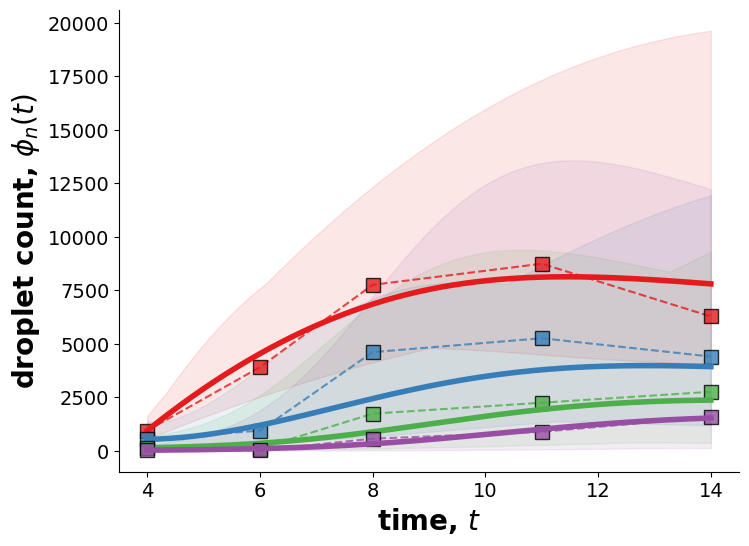

In [117]:
ppc_plot(
    pool_id=1,
    gene_id="NTC (avg)",
    noise_model="lognormal"
)

In [28]:
noise_model = "multiplicative normal"

pool_ids = [1,2]

for p, pool_id in enumerate(pool_ids):

    all_gene_ids = data_handler.get_pool_gene_ids(pool_id=pool_id)

    for g, gene_id in enumerate(all_gene_ids):

        save_path = Path(f"../Results/{noise_model}/preliminary dataset/pool {pool_id}/{gene_id}/pool {pool_id} {gene_id} PPC timecourse plot.png")

        ppc_plot(
            pool_id=pool_id,
            gene_id=gene_id,
            noise_model=noise_model,
            fig_size=(8,6),
            y_max=12000,
            save_fig=True,
            save_path=save_path
        )

---

### Residual diagnostics

In [114]:
def produce_residual_diagnostic_plots(
    pool_id=pool_id,
    gene_id=gene_id,
    noise_model=noise_model,
    fig_size=(8,6),
    save_figs=True
):

    def _get_clean_array(array):
        clean = []

        for x in array:
            try:
                val = float(x)
                clean.append(val)
            except (ValueError, TypeError):
                pass  # skip invalid entries

        clean = np.asarray(clean)

        return clean
    

    def _clean_residuals(model_sol, residuals, remove_zeros=True):

        model_sol_flat = model_sol.ravel()

        cleaned_model_sol = []
        cleaned_residuals = []
        for i, x in enumerate(residuals.ravel()):
            try:
                val = float(x)
                if np.isfinite(val):
                    if remove_zeros:
                        if val != 0:
                            cleaned_residuals.append(val)
                            cleaned_model_sol.append(model_sol_flat[i])
                    else:
                        cleaned_residuals.append(val)
                        cleaned_model_sol.append(model_sol_flat[i])
            except (ValueError, TypeError):
                pass  # skip non-numeric entries

        return np.array(cleaned_model_sol), np.array(cleaned_residuals)
    

    # def _get_num_outputs(sigmas, remove_zeros=True):

    #     loop = True
    #     N = 1
    #     while loop:
    #         x = sigmas[N-1]
    #         try:
    #             val = float(x)
    #             if np.isfinite(val):
    #                 if remove_zeros:
    #                     if val != 0:
    #                         cleaned_residuals.append(val)
    #                         cleaned_model_sol.append(model_sol_flat[i])
    #                 else:
    #                     cleaned_residuals.append(val)
    #                     cleaned_model_sol.append(model_sol_flat[i])
    #         except (ValueError, TypeError):
    #             pass  # skip non-numeric entries



    


    data_array = data_handler.get_gene_average_array(pool_id=pool_id, gene_id=gene_id, max_bin_number=51)
    initial_conditions = data_array[0]

    model = DropletModel(initial_conditions=initial_conditions)
    data_times = data_handler.data_times

    read_file_path = Path(f"../Results/{noise_model}/preliminary dataset/pool {pool_id}/opt_params.csv")
    opt_params_df = pd.read_csv(read_file_path, low_memory=False, keep_default_na=False)
    opt_params_row = opt_params_df[opt_params_df["gene_id"] == gene_id].iloc[0].to_numpy()[1:]
    model_mle_params = opt_params_row[:3]
    sigma_mles = opt_params_row[3:]

    model_sol = model.simulate(model_mle_params, data_times)

    if noise_model == "least squares":

        sigma_mles = list(opt_params_row[3:]) * 51

        residuals = (data_array - model_sol) / sigma_mles

    elif noise_model == "additive normal":

        residuals = (data_array - model_sol) / sigma_mles

    elif noise_model == "multiplicative normal":
        
        clean_sigmas =_get_clean_array(sigma_mles)
        num_sigmas = len(clean_sigmas)

        residuals = ((data_array[:, :num_sigmas] - model_sol[:, :num_sigmas]) / model_sol[:, :num_sigmas]) / clean_sigmas

    elif noise_model == "lognormal":

        residuals = (np.log(data_array) - np.log(model_sol)) / sigma_mles

    else:
        raise ValueError("noise model not valid")
    
    clean_model_sol, clean_residuals = _clean_residuals(model_sol, residuals, remove_zeros=True)


    save_directory = f"../Results/{noise_model}/preliminary dataset/pool {pool_id}/{gene_id}"


    fig, ax = plt.subplots(figsize=fig_size)
    x = np.linspace(-4,4,400)
    ax.hist(clean_residuals, bins=15, density=True, alpha=0.5)
    ax.plot(x, st.norm.pdf(x), 'r', lw=2)
    ax.set_title("Histogram of standardised residuals")

    if not save_figs:
        plt.show()

    else:

        fig.savefig(Path(save_directory + f"/pool {pool_id} {gene_id} residuals histogram"))   # save the figure to file
        plt.close(fig) 

    fig, ax = plt.subplots(figsize=fig_size)
    st.probplot(clean_residuals, dist="norm", plot=ax)
    ax.set_title("Normal Q–Q plot")

    if not save_figs:
        plt.show()

    else:

        fig.savefig(Path(save_directory + f"/pool {pool_id} {gene_id} qq plot"))   # save the figure to file
        plt.close(fig) 




    # plt.scatter(clean_model_sol, clean_residuals, alpha=0.6)
    # plt.axhline(0, color='k')
    # plt.xlabel("Fitted value")
    # plt.ylabel("Standardised residual")
    # plt.show()



In [115]:
noise_model = "least squares"

pool_ids = [1,2]

for pool_id in pool_ids:
    
    all_gene_ids = data_handler.get_pool_gene_ids(pool_id=pool_id)

    for g, gene_id in enumerate(all_gene_ids):
        produce_residual_diagnostic_plots(
            pool_id=pool_id,
            gene_id=gene_id,
            noise_model=noise_model
        )

---

### Bayesian chain pairwise plots

In [110]:
def produce_pairwise_chain_plots(
    pool_id,
    gene_id,
    noise_model,
    save_fig=False
):

    data_array = data_handler.get_gene_average_array(pool_id=pool_id, gene_id=gene_id, max_bin_number=51)
    initial_conditions = data_array[0]

    model = DropletModel(initial_conditions=initial_conditions)
    data_times = data_handler.data_times
    num_model_times = 200
    model_times = np.linspace(4, 14, num_model_times)

    read_file_path = Path(f"../Results/{noise_model}/preliminary dataset/pool {pool_id}/opt_params.csv")
    opt_params_df = pd.read_csv(read_file_path, low_memory=False, keep_default_na=False)
    opt_params_row = opt_params_df[opt_params_df["gene_id"] == gene_id].iloc[0].to_numpy()[1:]
    model_mle_params = opt_params_row[:3]

    num_chains = 4
    burnt_in_chains = []

    for c in range(num_chains):

        chain_read_path = Path(f"../Results/{noise_model}/preliminary dataset/pool {pool_id}/{gene_id}/profile mcmc/chain {c+1}.csv")

        chain_df = pd.read_csv(chain_read_path, low_memory=False, keep_default_na=False)
        chain = chain_df.to_numpy()
        burnt_in_chain = chain[int(chain.shape[0]/2):, :]
        burnt_in_chains.append(burnt_in_chain)

    burnt_in_chains = np.asarray(burnt_in_chains)
    stacked_chains = np.vstack(burnt_in_chains)


    pints.plot.pairwise(
        stacked_chains, 
        kde=True, 
        parameter_names=["b", "f", "g"],
        ref_parameters=model_mle_params
    )

    if not save_fig:
        plt.show()

    else:

        save_directory = f"../Results/{noise_model}/preliminary dataset/pool {pool_id}/{gene_id}"

        plt.savefig(Path(save_directory + f"/pool {pool_id} {gene_id} Bayesian pairwise plot"))   # save the figure to file
        plt.close() 

In [113]:
noise_model = "lognormal"

pool_ids = [1,2]

for pool_id in pool_ids:
    
    all_gene_ids = data_handler.get_pool_gene_ids(pool_id=pool_id)

    all_gene_ids = ["NTC (avg)"]

    for g, gene_id in enumerate(all_gene_ids):
        produce_pairwise_chain_plots(
            pool_id=pool_id,
            gene_id=gene_id,
            noise_model=noise_model,
            save_fig=True
        )

---

### Synthetic data plots